In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import RobustScaler

import holidays

## Energy Dataset

In [2]:
path = 'df_energy.csv'
df = pd.read_csv(path)

df.head()

,datetime,pittsburgh_temp,chicago_temp,Duquesne_kW,ComEdison_kW,is_NWD
0,2012-10-01 08:00:00-04:00,NaN,NaN,2.716667,2.82550,0
1,2012-10-01 09:00:00-04:00,7.850000,10.860000,2.733333,2.85650,0
2,2012-10-01 10:00:00-04:00,7.874767,10.904691,2.745000,2.88050,0
3,2012-10-01 11:00:00-04:00,7.938319,11.027412,2.716667,2.89350,0
4,2012-10-01 12:00:00-04:00,8.001870,11.150133,2.711667,2.87225,0


In [3]:
# separate the data
df_pittsburgh = df[['datetime', 'pittsburgh_temp', 'Duquesne_kW', 'is_NWD']].copy()

# convert datetime to datetime object
df_pittsburgh['datetime'] = pd.to_datetime(df_pittsburgh['datetime'], utc=True)

# add hour of day
df_pittsburgh['hour'] = df_pittsburgh['datetime'].dt.hour

# add hour of the year
df_pittsburgh['hour_of_year'] = df_pittsburgh['datetime'].dt.dayofyear * 24 + df_pittsburgh['datetime'].dt.hour

# add day of the week
df_pittsburgh['day_of_week'] = df_pittsburgh['datetime'].dt.dayofweek

# add US holidays
df_pittsburgh['is_holiday'] = df_pittsburgh['datetime'].apply(lambda x: x in holidays.US())

# remove is_NWD
df_pittsburgh = df_pittsburgh.drop(columns=['is_NWD'])

In [4]:
# check for missing values
df_pittsburgh.isnull().sum()

datetime           0
pittsburgh_temp    3
Duquesne_kW        0
hour               0
hour_of_year       0
day_of_week        0
is_holiday         0
dtype: int64

In [5]:
# fill missing values with average between adjacent values
df_pittsburgh['pittsburgh_temp'] = df_pittsburgh['pittsburgh_temp'].interpolate(method='linear')

# remove first row
df_pittsburgh = df_pittsburgh.drop(df_pittsburgh.index[0])

# reset index
df_pittsburgh = df_pittsburgh.reset_index(drop=True)

# check again
df_pittsburgh.isnull().sum()

datetime           0
pittsburgh_temp    0
Duquesne_kW        0
hour               0
hour_of_year       0
day_of_week        0
is_holiday         0
dtype: int64

In [6]:
df_pittsburgh.head()

,datetime,pittsburgh_temp,Duquesne_kW,hour,hour_of_year,day_of_week,is_holiday
0,2012-10-01 13:00:00+00:00,7.850000,2.733333,13,6613,0,False
1,2012-10-01 14:00:00+00:00,7.874767,2.745000,14,6614,0,False
2,2012-10-01 15:00:00+00:00,7.938319,2.716667,15,6615,0,False
3,2012-10-01 16:00:00+00:00,8.001870,2.711667,16,6616,0,False
4,2012-10-01 17:00:00+00:00,8.065421,2.695000,17,6617,0,False


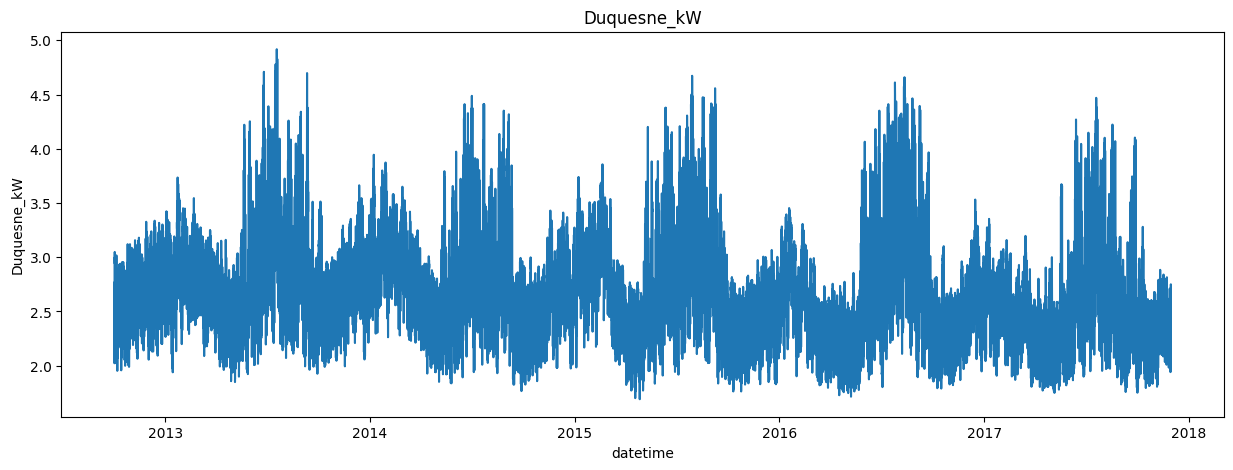

In [7]:
# plot the data
plt.figure(figsize=(15, 5))
sns.lineplot(x='datetime', y='Duquesne_kW', data=df_pittsburgh)
plt.title('Duquesne_kW')
plt.xlabel('')
plt.ylabel('kW per customer')
plt.show()

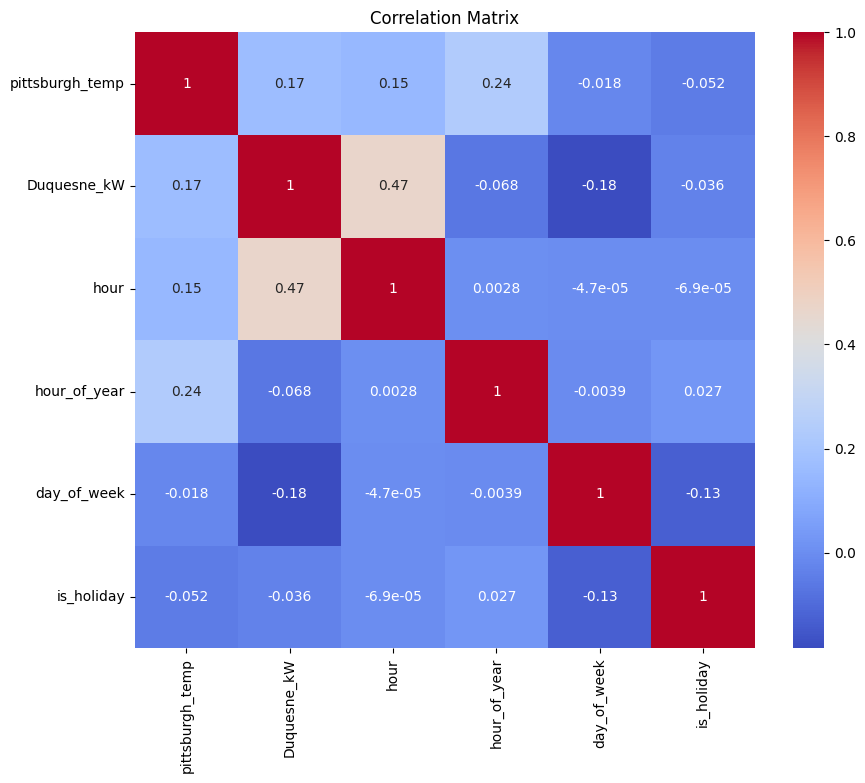

In [8]:
# cols to scale all except datetime
cols_to_scale = df_pittsburgh.columns[1:]

# instantiate the scaler
scaler = RobustScaler()

# fit the scaler
df_scaled = scaler.fit_transform(df_pittsburgh[cols_to_scale]).copy()

# create a new dataframe
df_scaled = pd.DataFrame(df_scaled, columns=cols_to_scale)

# calculate corr matrix
corr_matrix = df_scaled.corr()

# plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

No strong intercorrelation among features. While XGBoost is robust, addressing multicollinearity can improve model interpretability and stability.

In [9]:
"""
Note: It really doesn't change the results if we use RobustScaler or not,
so to get a better understanding of the data, we will use the original data.
"""
# # prepare the features and target
# X = df_scaled.drop(columns=['Duquesne_kW', 'datetime'])
# y = df_scaled['Duquesne_kW']

# prepare the features and target
X = df_pittsburgh.drop(columns=['Duquesne_kW']).copy()
y = df_pittsburgh['Duquesne_kW'].copy()

# specify feature columns for XGBoost, we need to exclude 'datetime'
feature_cols = [col for col in X.columns if col != 'datetime']

# define the split point
split_date = pd.to_datetime('2017-01-01 00:00:00+00:00')

# split the data based on the datetime
X_train = X[X['datetime'] < split_date]
X_test = X[X['datetime'] >= split_date]
y_train = y[X['datetime'] < split_date]
y_test = y[X['datetime'] >= split_date]

In [10]:
# initialize XGBoost model
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# train the model
model.fit(X_train[feature_cols], y_train)

# make predictions
y_pred = model.predict(X_test[feature_cols])

# evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"## Mean Squared Error: {mse}")
print(f"## Mean Absolute Error: {mae}")
print(f"## Root Mean Squared Error: {rmse}")

# feature importance
print("## Feature Importance:")
feature_importance = model.feature_importances_
for feature, importance in zip(X[feature_cols].columns, feature_importance):
    print(f"{feature}: {importance}")

## Mean Squared Error: 0.04119659703087984
## Mean Absolute Error: 0.17099502049746976
## Root Mean Squared Error: 0.202969448515977
## Feature Importance:
pittsburgh_temp: 0.33422255516052246
hour: 0.430448055267334
hour_of_year: 0.06319191306829453
day_of_week: 0.12072714418172836
is_holiday: 0.05141035467386246


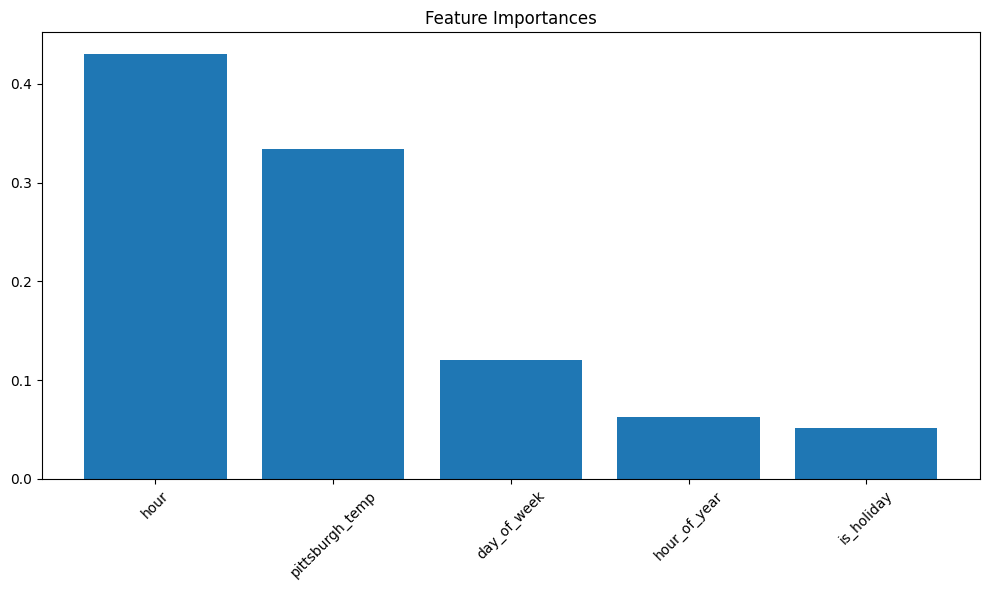

In [11]:
# sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# create plot
plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(X[feature_cols].shape[1]), feature_importance[indices])
plt.xticks(range(X[feature_cols].shape[1]), [X[feature_cols].columns[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

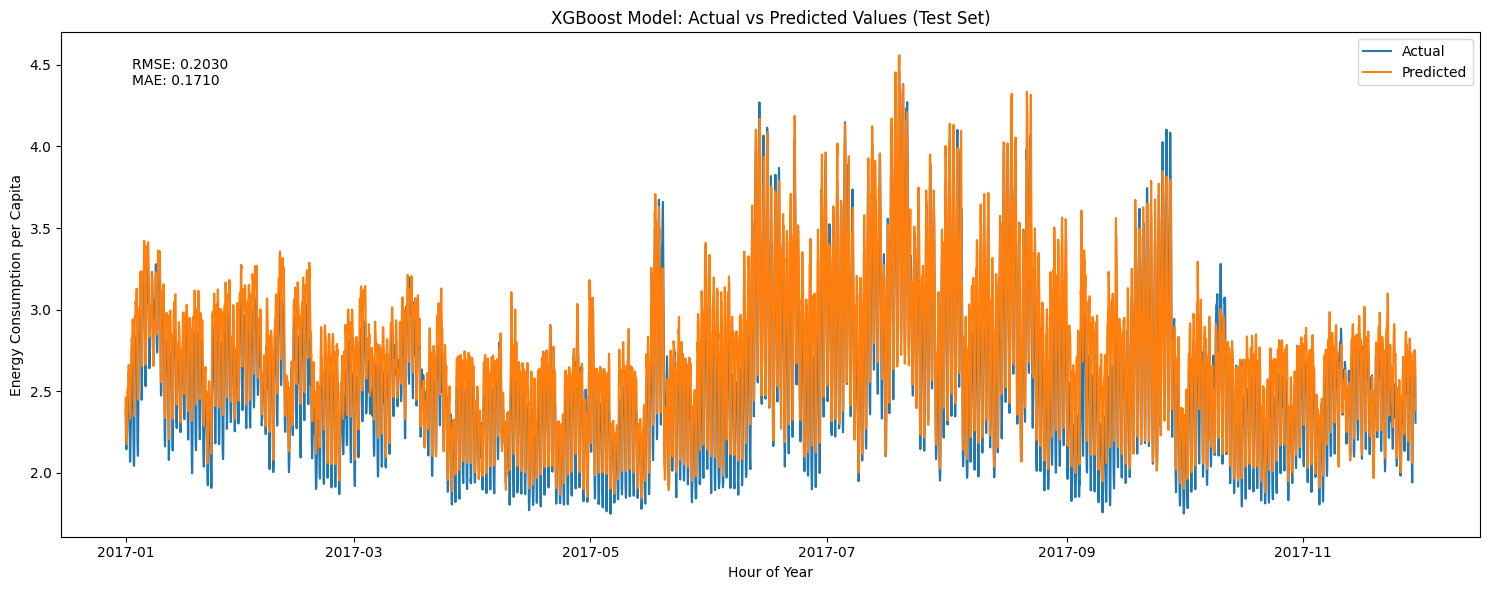

In [12]:
# create a dataframe with test values, predictions, and hour_of_year
df_results = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'datetime': X_test['datetime'],
    'hour_of_year': X_test['hour_of_year'],
    'hour_of_week': X_test['datetime'].dt.dayofweek * 24 + X_test['datetime'].dt.hour
})

# sort the dataframe by datetime
df_results_sorted = df_results.sort_values('datetime')

# create the line plot
plt.figure(figsize=(15, 6))
plt.plot(df_results_sorted['datetime'], df_results_sorted['actual'], label='Actual')
plt.plot(df_results_sorted['datetime'], df_results_sorted['predicted'], label='Predicted')

# customize the plot
plt.title('XGBoost Model: Actual vs Predicted Values (Test Set)')
plt.xlabel('Hour of Year')
plt.ylabel('Energy Consumption per Capita')
plt.legend()

# add text with performance metrics
plt.text(0.05, 0.95, f'RMSE: {rmse:.4f}\nMAE: {mae:.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

When comparing the predicted vs actual energy demand values we can see a small overstimation on the predictions. If we check the corresponding plot on the time_series_EDA notebook, we can see a descending trend (which explains the model overstimation).

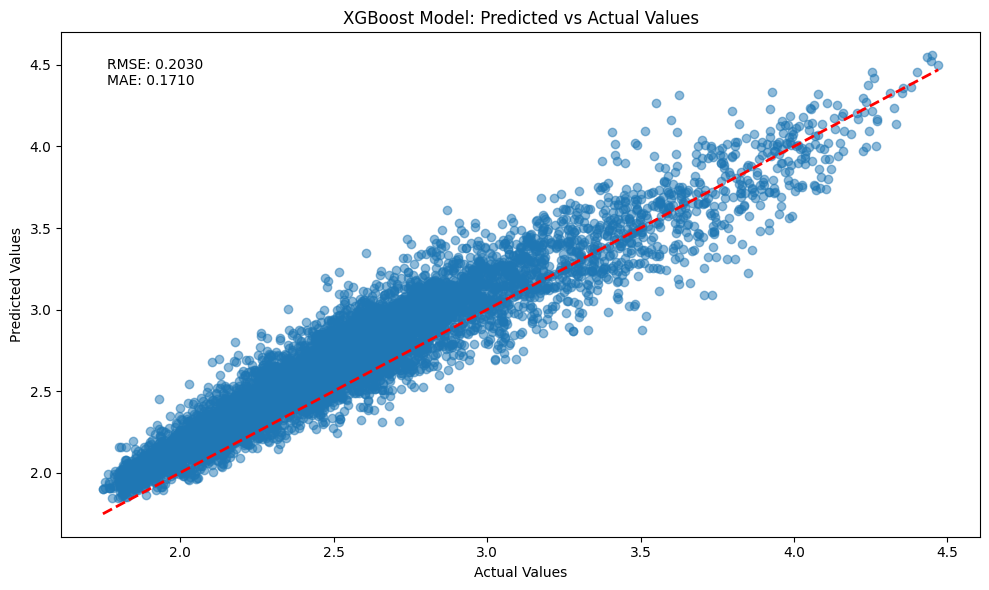

In [13]:
# create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)

# add a perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

# customize the plot
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost Model: Predicted vs Actual Values')

# add text with performance metrics
plt.text(0.05, 0.95, f'RMSE: {rmse:.4f}\nMAE: {mae:.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

As said before and corroborated in the plot above, the predictions overestimate the energy demand. Beside that, the errors have a good distribution (by displacing the perfect prediction line)

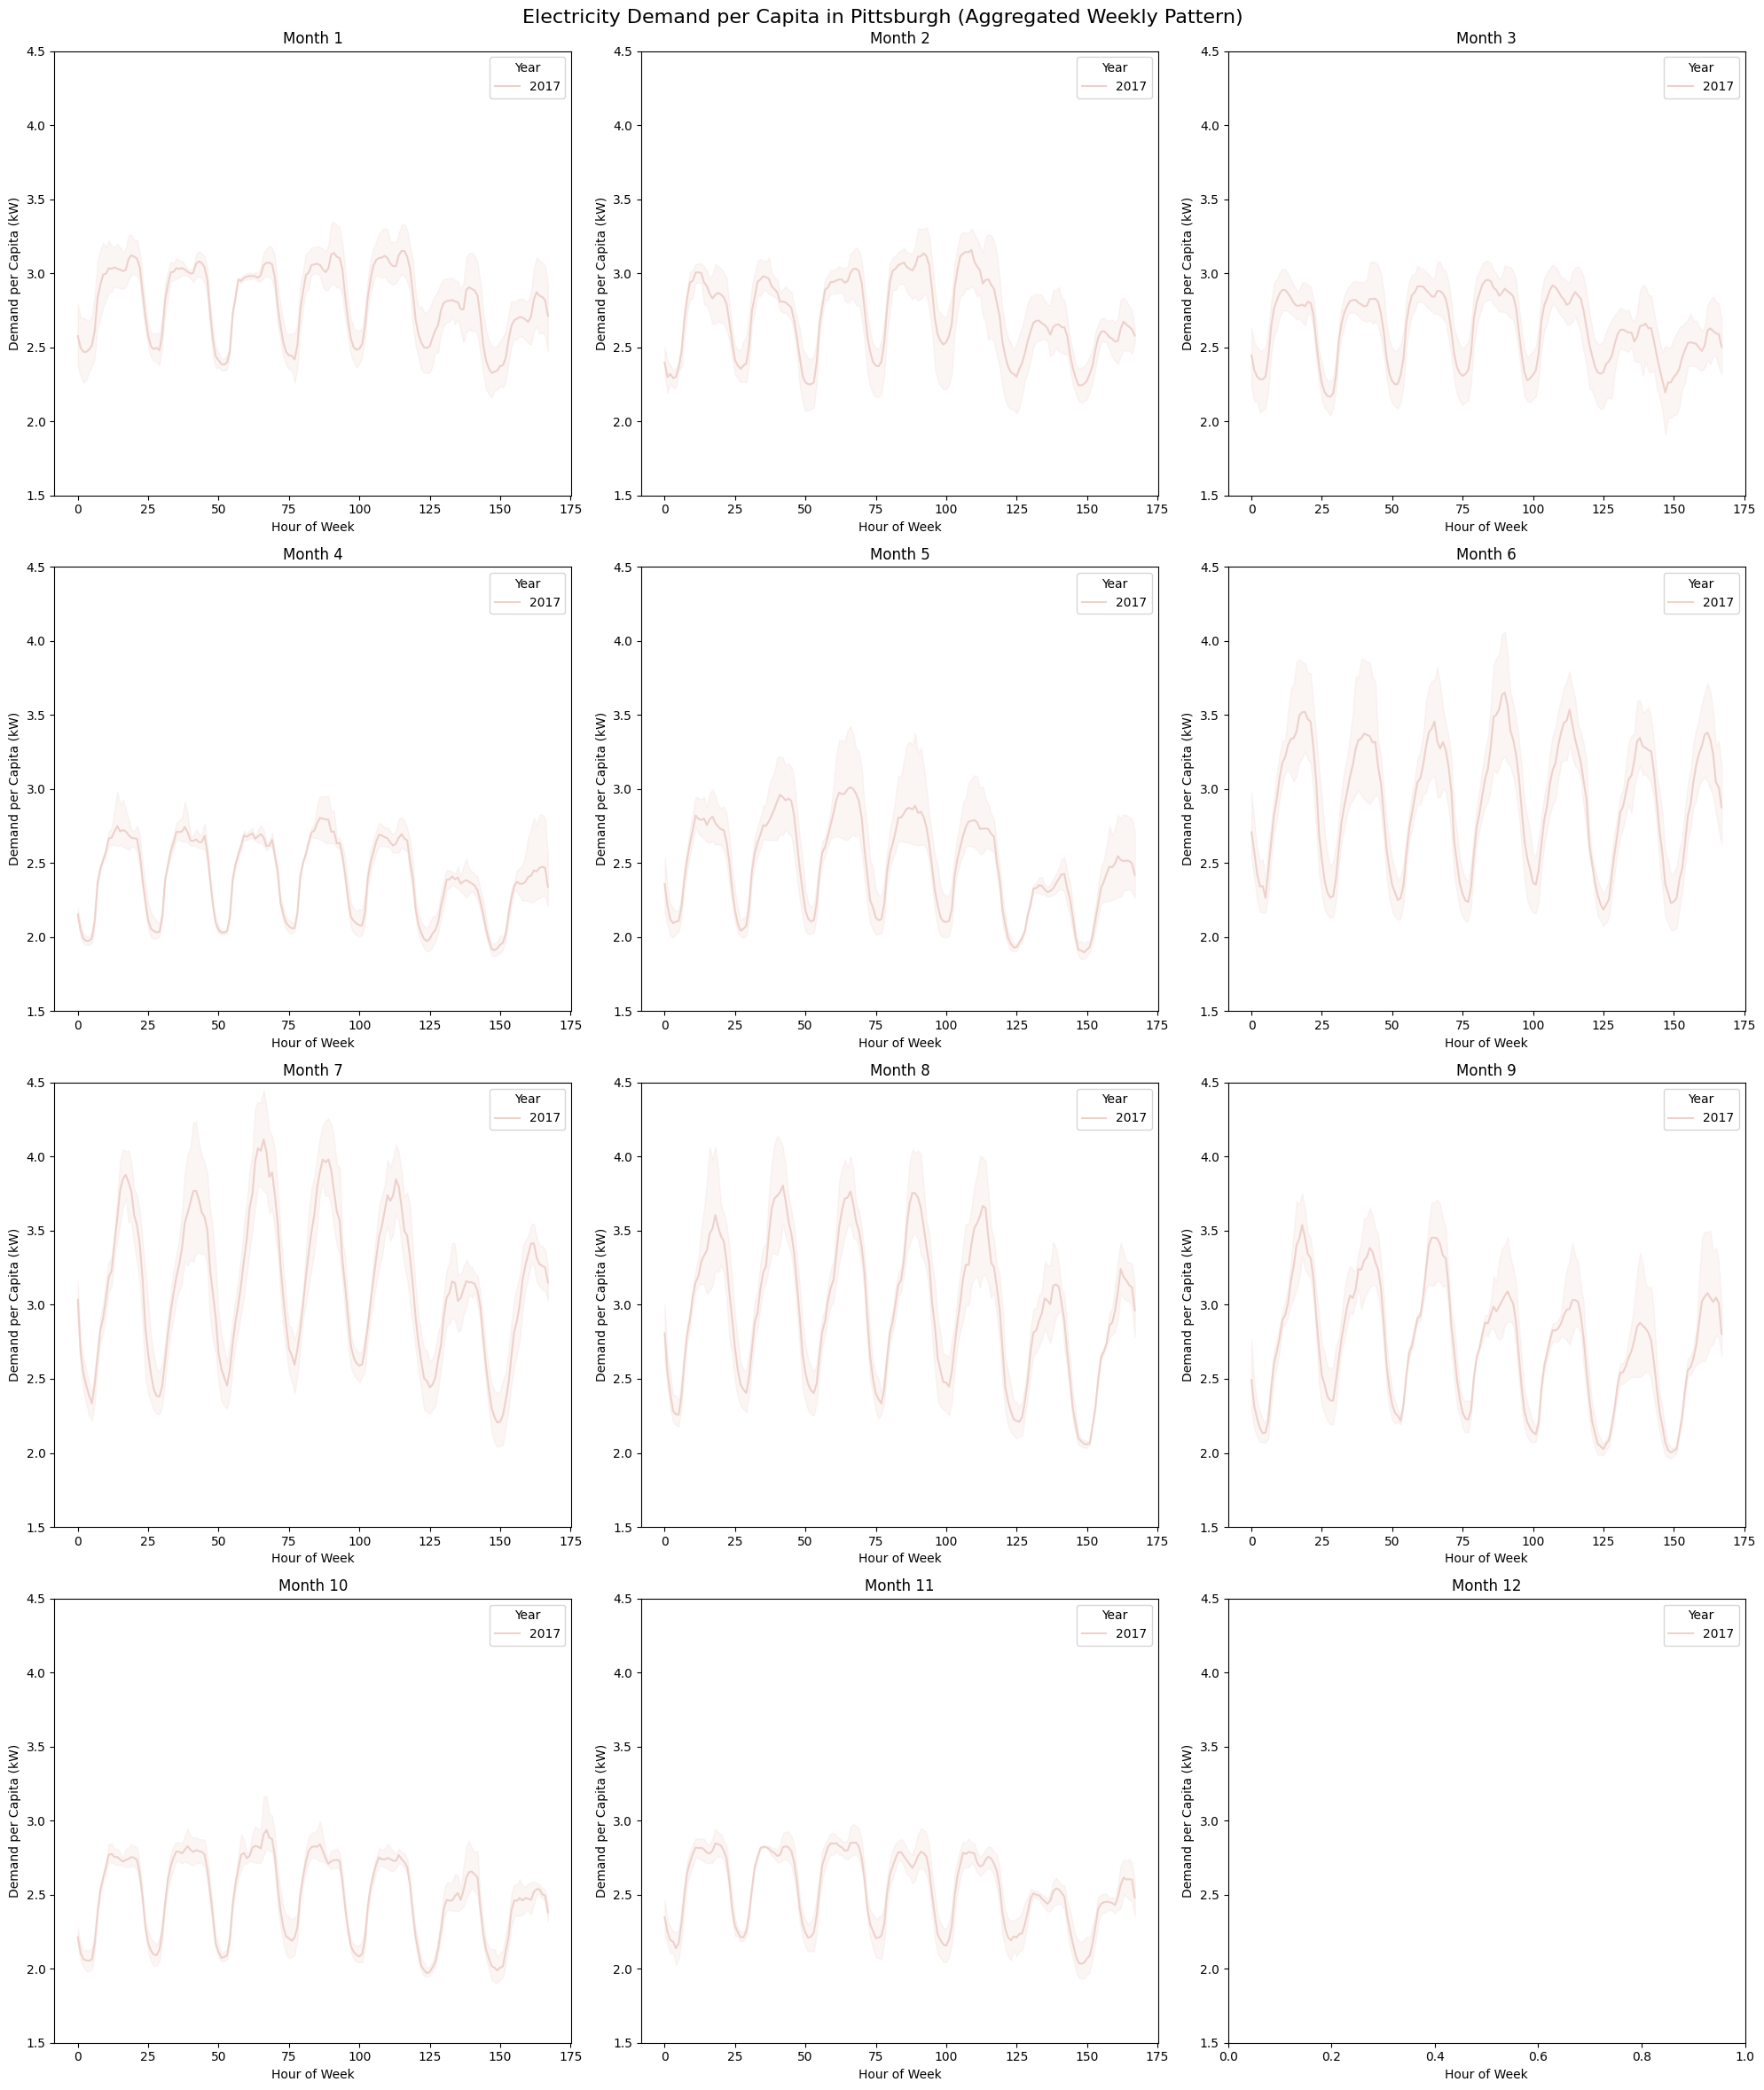

In [14]:
# create a 4x3 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 24))
fig.suptitle('Electricity Demand per Capita in Pittsburgh (Aggregated Weekly Pattern)\n', fontsize=16)

# flatten the axes array for easier iteration
axes = axes.flatten()

# plot energy load per capita for each month
for i, ax in enumerate(axes, start=1):
    sns.lineplot(
        data=df_results_sorted[df_results_sorted['datetime'].dt.month == i],
        x='hour_of_week',
        y='predicted',
        hue=df_results_sorted['datetime'].dt.year,
        # errorbar=None,
        linewidth=1.5,
        ax=ax
    )

    # customize each subplot
    ax.set_title(f'Month {i}')
    ax.set_xlabel('Hour of Week')
    ax.set_ylabel('Demand per Capita (kW)')
    ax.set_ylim(1.5, 4.5) # unify scale
    ax.legend(title='Year', loc='upper right')

# adjust layout and show the plot
plt.tight_layout()
plt.show()

The general energy demmand patterns by week and day present a good similitude as observed in the 'time series EDA' notebook, capturing also the lower consumption on weekends.

## Influenza Like Illness Activity Levels Dataset

In [15]:
path = 'df_pennsylvania_flu.csv'
df_pennsylvania_flu = pd.read_csv(path)

df_pennsylvania_flu.head()

,year,week,temp_mean,temp_min,temp_max,cold_hours,hot_hours,activity_level,activity_level_label,season
0,2012,40,15.683834,7.45,23.35,37,0,1,Minimal,2012-13
1,2012,41,7.817202,0.02,18.15,116,0,1,Minimal,2012-13
2,2012,42,12.615952,3.75,24.14,66,0,1,Minimal,2012-13
3,2012,43,15.317589,3.30,27.65,36,6,1,Minimal,2012-13
4,2012,44,4.587870,1.98,7.91,169,0,1,Minimal,2012-13


In [16]:
# check for missing values
df_pennsylvania_flu.isnull().sum()

year                    0
week                    0
temp_mean               0
temp_min                0
temp_max                0
cold_hours              0
hot_hours               0
activity_level          0
activity_level_label    0
season                  0
dtype: int64

In [17]:
# add a date column starting on monday
df_pennsylvania_flu['date'] = pd.to_datetime(
    df_pennsylvania_flu['year'].astype(str) + '-W' + df_pennsylvania_flu['week'].astype(str).str.zfill(2) + '-1', 
    format='%Y-W%W-%w')

# set the date as index (for commodity, the code is already written)
df_pennsylvania_flu = df_pennsylvania_flu.set_index('date')

# display the updated dataframe to remember the other columns to plot
display(df_pennsylvania_flu.head())

,year,week,temp_mean,temp_min,temp_max,cold_hours,hot_hours,activity_level,activity_level_label,season
date,,,,,,,,,,
2012-10-01,2012,40,15.683834,7.45,23.35,37,0,1,Minimal,2012-13
2012-10-08,2012,41,7.817202,0.02,18.15,116,0,1,Minimal,2012-13
2012-10-15,2012,42,12.615952,3.75,24.14,66,0,1,Minimal,2012-13
2012-10-22,2012,43,15.317589,3.30,27.65,36,6,1,Minimal,2012-13
2012-10-29,2012,44,4.587870,1.98,7.91,169,0,1,Minimal,2012-13


In [18]:
# add cold and hot threshold
cold_threshold = 15
hot_threshold = 25

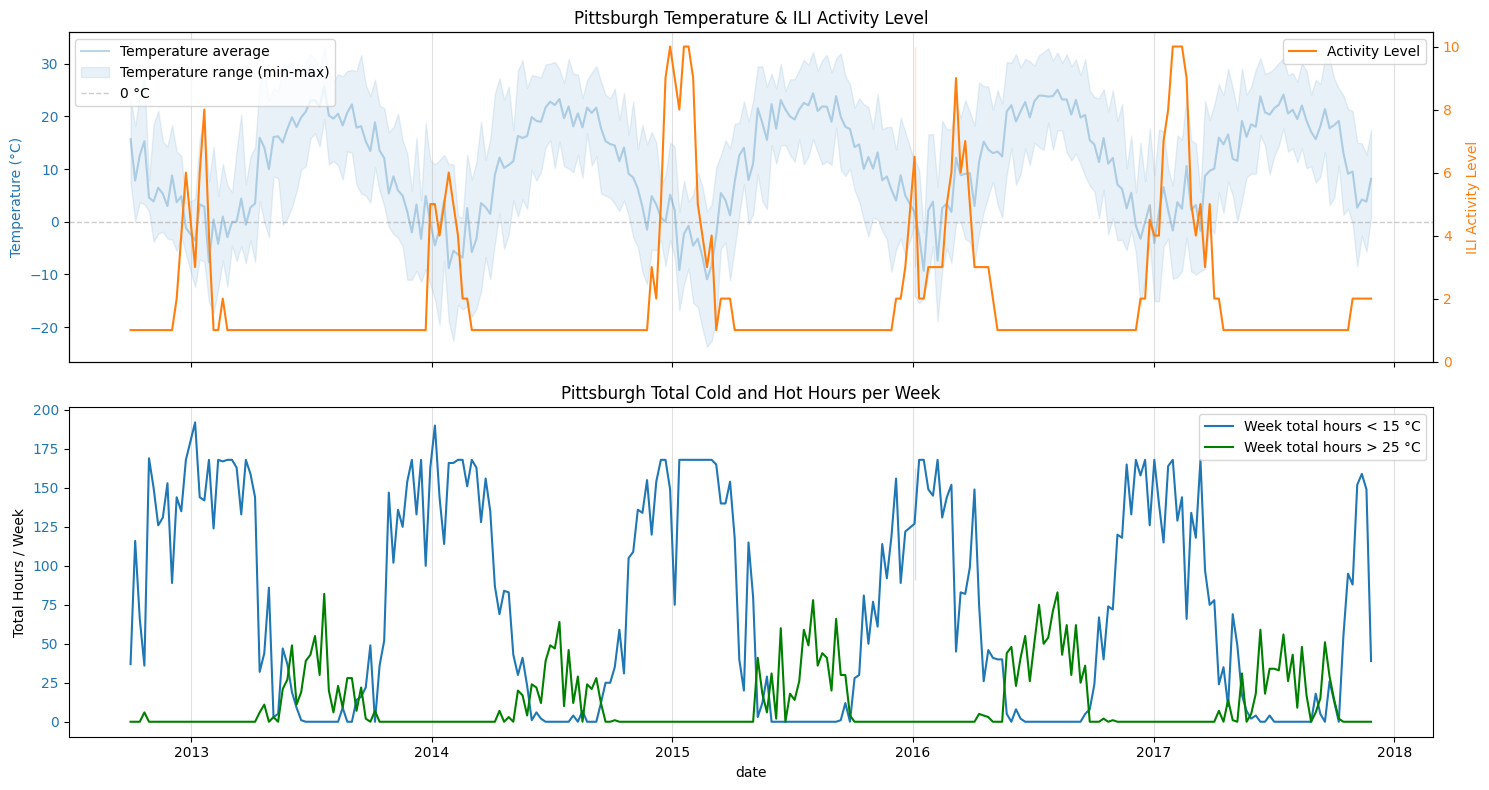

In [19]:
# general seasonal patterns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# plot raw temperatures
sns.lineplot(data=df_pennsylvania_flu, x='date', y='temp_mean', label='Temperature average', ax=ax1, 
             color='#1f77b4', alpha=0.3
             )
ax1.fill_between(df_pennsylvania_flu.index, df_pennsylvania_flu['temp_min'], df_pennsylvania_flu['temp_max'], 
                 alpha=0.1, color='#1f77b4', label='Temperature range (min-max)'
                 ) # min-max band
ax1.set_ylabel('Temperature (°C)', color='#1f77b4')
ax1.tick_params(axis='y', labelcolor='#1f77b4')
ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.4, label='0 °C') # add 0 °C line

# create a second y-axis ILI activity
ax1_activity = ax1.twinx()
sns.lineplot(data=df_pennsylvania_flu, x='date', y='activity_level', label='Activity Level', ax=ax1_activity, color='#ff7f0e')
ax1_activity.set_ylabel('ILI Activity Level', color='#ff7f0e')
ax1_activity.tick_params(axis='y', labelcolor='#ff7f0e')
ax1_activity.set_ylim(bottom=0)

# set title for the first subplot
ax1.grid(axis='x', alpha=0.4)
ax1.set_title('Pittsburgh Temperature & ILI Activity Level')
ax1.legend(loc='upper left')

# plot total hot/cold hours per week
sns.lineplot(data=df_pennsylvania_flu, x='date', y='cold_hours', label=f'Week total hours < {cold_threshold} °C', ax=ax2, color='#1f77b4')
sns.lineplot(data=df_pennsylvania_flu, x='date', y='hot_hours', label=f'Week total hours > {hot_threshold} °C', ax=ax2, color='green')
ax2.set_ylabel('Total Hours / Week')
ax2.tick_params(axis='y', labelcolor='#1f77b4')

# title / labels 2nd subplot
ax2.set_title('Pittsburgh Total Cold and Hot Hours per Week')
ax2.grid(axis='x', alpha=0.4)
ax2.legend(loc='upper right')

# adjust layout and show plot
plt.tight_layout()
plt.show()

In [20]:
# drop year, activity_level_label and season columns
df_pennsylvania_flu = df_pennsylvania_flu.drop(columns=['year', 'activity_level_label', 'season'])

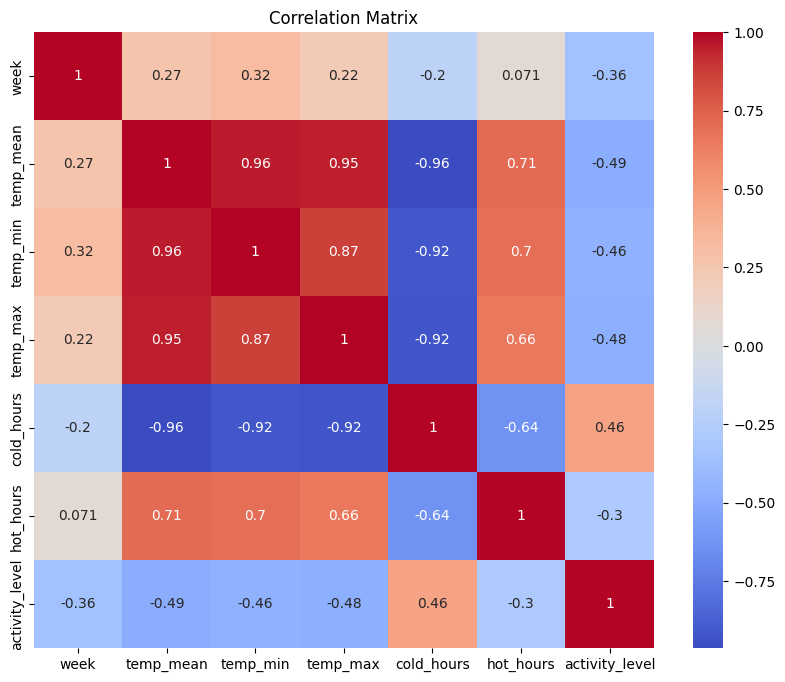

In [21]:
# instantiate the scaler
scaler = RobustScaler()

# fit the scaler
df_scaled = scaler.fit_transform(df_pennsylvania_flu).copy()

# convert the scaled data back to a DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=df_pennsylvania_flu.columns, index=df_pennsylvania_flu.index)

# calculate corr matrix
corr_matrix = df_scaled.corr()

# plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

 Although XGBoost is resistant to collinearity, it's best practice to avoid highly correlated features. We should evaluate the model's performance with and without correlated features, for example, by comparing results using temp_mean alone versus including both temp_mean and hot/cold_hours.

In [22]:
# prepare the features and target
X = df_scaled.drop(columns=['activity_level']).copy()
y = df_scaled['activity_level'].copy()

# specify feature columns for XGBoost, we need to exclude 'datetime'
feature_cols = [col for col in X.columns if col != 'date']

# define the split point
split_date = pd.to_datetime('2016-07-01')

# split the data based on the datetime
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[X.index < split_date]
y_test = y[X.index >= split_date]

In [23]:
# initialize XGBoost model
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# train the model
model.fit(X_train[feature_cols], y_train)

# make predictions
y_pred = model.predict(X_test[feature_cols])

# evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"## Mean Squared Error: {mse}")
print(f"## Mean Absolute Error: {mae}")
print(f"## Root Mean Squared Error: {rmse}")

# feature importance
print("## Feature Importance:")
feature_importance = model.feature_importances_
for feature, importance in zip(X[feature_cols].columns, feature_importance):
    print(f"{feature}: {importance}")

## Mean Squared Error: 2.661031303575848
## Mean Absolute Error: 0.7136783962479482
## Root Mean Squared Error: 1.631266778787531
## Feature Importance:
week: 0.5268691182136536
temp_mean: 0.15125490725040436
temp_min: 0.0860019251704216
temp_max: 0.1461493819952011
cold_hours: 0.04434629902243614
hot_hours: 0.04537833482027054


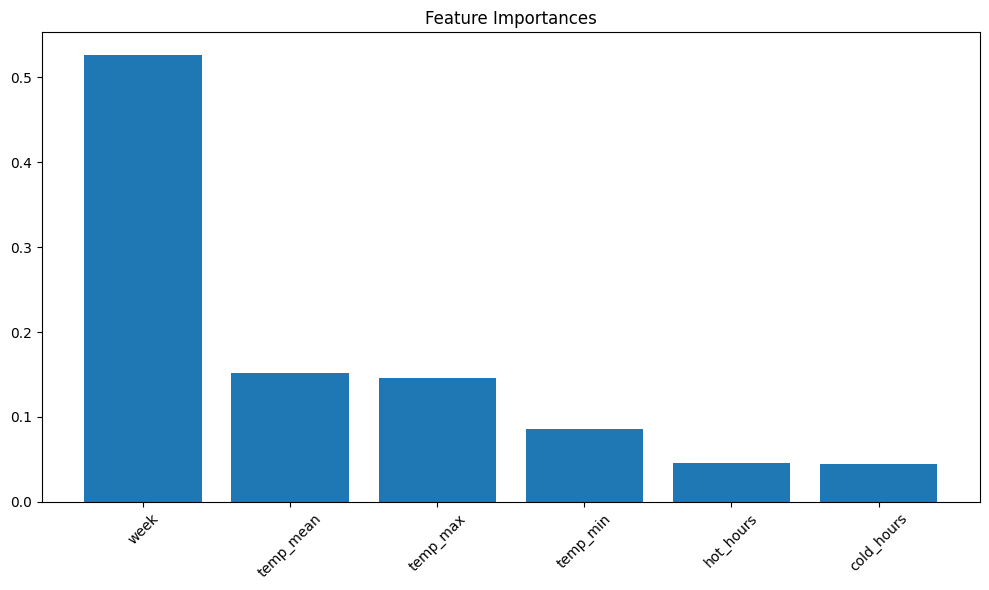

In [24]:
# sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# create plot
plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(X[feature_cols].shape[1]), feature_importance[indices])
plt.xticks(range(X[feature_cols].shape[1]), [X[feature_cols].columns[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

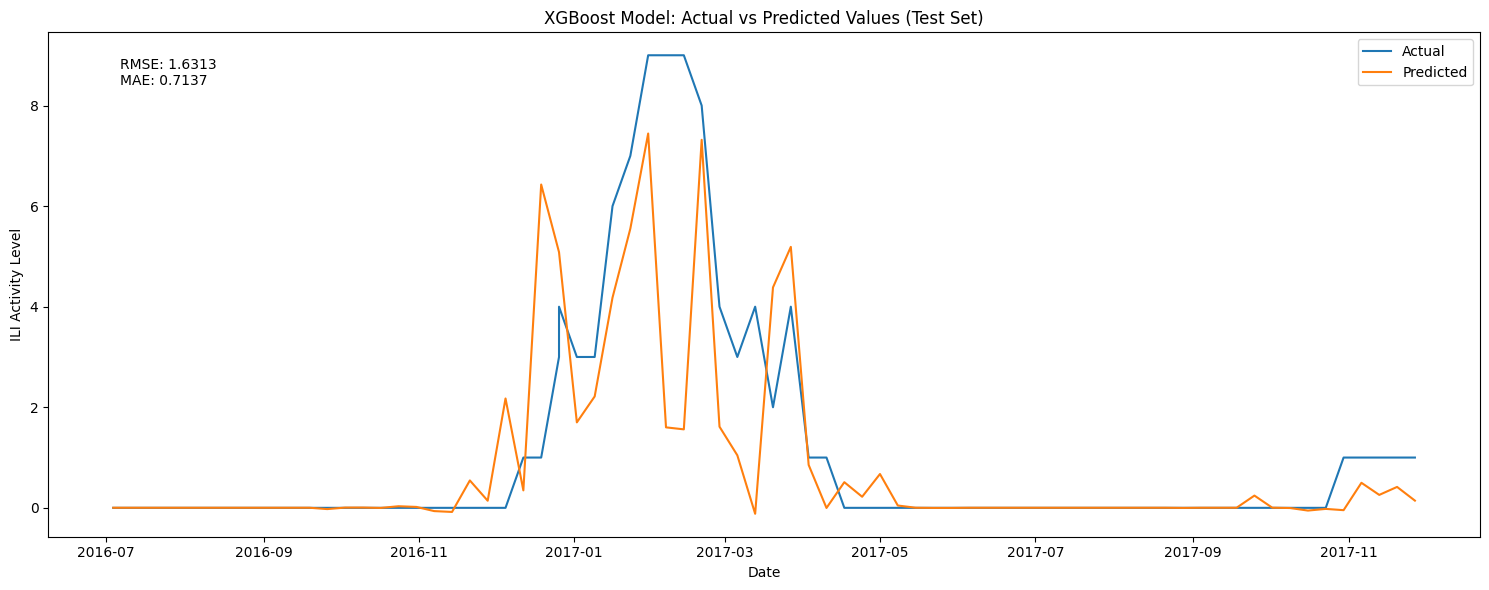

In [25]:
# create a dataframe with test values, predictions, and hour_of_year
df_results = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
})

# sort the DataFrame by the index
df_results_sorted = df_results.sort_index()

# create the line plot
plt.figure(figsize=(15, 6))
plt.plot(df_results_sorted.index, df_results_sorted['actual'], label='Actual')
plt.plot(df_results_sorted.index, df_results_sorted['predicted'], label='Predicted')

# customize the plot
plt.title('XGBoost Model: Actual vs Predicted Values (Test Set)')
plt.xlabel('Date')
plt.ylabel('ILI Activity Level')
plt.legend()

# add text with performance metrics
plt.text(0.05, 0.95, f'RMSE: {rmse:.4f}\nMAE: {mae:.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

Even though the activity level shows a 1-year cyclical pattern (but not strictly periodical, as we observed in the 'time_series_EDA' notebook), the XGBoost model predicted with good precision the beginning, end, and approximate envelope shape of the ILI wave.

## Temperature Dataset

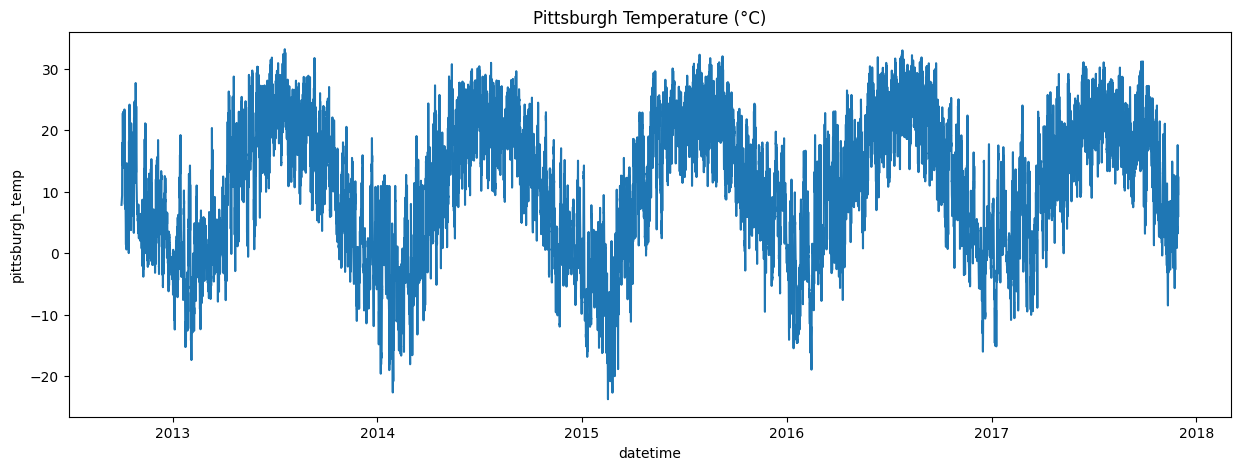

In [26]:
# plot the data
plt.figure(figsize=(15, 5))
sns.lineplot(x='datetime', y='pittsburgh_temp', data=df_pittsburgh)
plt.title('Pittsburgh Temperature (°C)')

plt.show()

In [ ]:
# define split date
split_date = pd.to_datetime('2017-01-01 00:00:00+00:00')

# separate train and test dataframes
df_train = df_pittsburgh[df_pittsburgh['datetime'] < split_date]
df_test = df_pittsburgh[df_pittsburgh['datetime'] >= split_date]

# prepare features and target
X_train = df_train['hour_of_year']
X_test = df_test['hour_of_year']
y_train = df_train['pittsburgh_temp']
y_test = df_test['pittsburgh_temp']

In [35]:
# initialize and train XGBoost Regressor
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
model.fit(X_train.to_frame(), y_train)  # convert to DataFrame

# make predictions
y_pred = model.predict(X_test.to_frame())  # convert to DataFrame

# evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")


Mean Squared Error: 45.93932235186703
Mean Absolute Error: 5.339120719338428
Root Mean Squared Error: 6.777855291452233


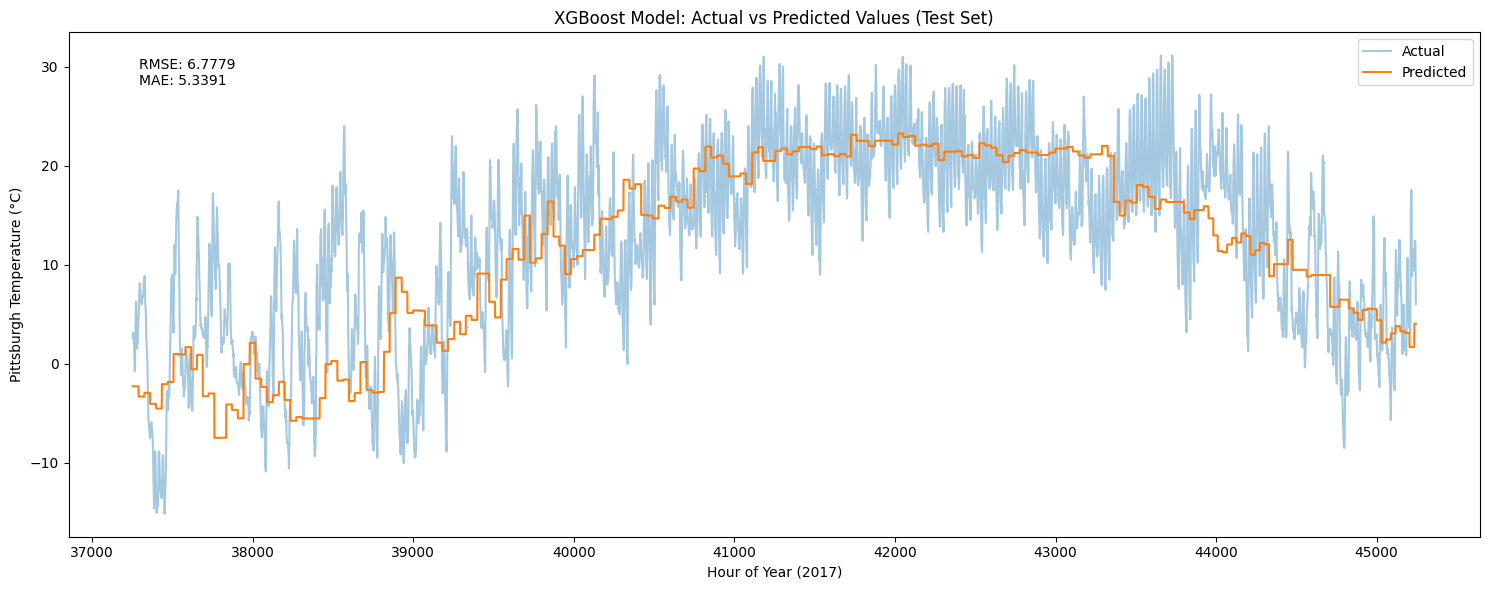

In [40]:
# create a dataframe with test values, predictions, and hour_of_year
df_results = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
})

# sort the DataFrame by the index
df_results_sorted = df_results.sort_index()

# create the line plot
plt.figure(figsize=(15, 6))
plt.plot(df_results_sorted.index, df_results_sorted['actual'], label='Actual', alpha=0.4)
plt.plot(df_results_sorted.index, df_results_sorted['predicted'], label='Predicted')

# customize the plot
plt.title('XGBoost Model: Actual vs Predicted Values (Test Set)')
plt.xlabel('Hour of Year (2017)')
plt.ylabel('Pittsburgh Temperature (°C)')
plt.legend()

# add text with performance metrics
plt.text(0.05, 0.95, f'RMSE: {rmse:.4f}\nMAE: {mae:.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

Not great, not terrible